In [1]:
#Libraries
push!(LOAD_PATH, "/home/jberez/Projects/BostonHousing/docker-parallel")
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using Serialization
using StatsBase
using BNN

include("utils.jl");
include("LoadData.jl");

In [2]:
#Load Boston Housing Data

dx, dy, x_train, x_test, y_train, y_test = load_data(10);

In [3]:
#Network hyperparameters
k_real = 4 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 8 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

#Hyperprior Hyperparameters
αᵧ = 1 #Regression Noise Shape
βᵧ = 1 #Regression Noise Scale/Rate
α₁ = 1 #Input Weights, Biases Shape
β₁ = 1 #Input Weights, Biases Scale/Rate
α₂ = 1 #Hidden & Output Weights Shape
β₂ = k_real; #Hidden & Output Weights Scale

#Bayesian Neural Network 

function G2(x, trace)
    activation = relu
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
    
end;

#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    τ = [0.0 for i=1:l+1]
    τᵦ = [0.0 for i=1:l+1]
    σ = [0.0 for i=1:l+1]
    σᵦ = [0.0 for i=1:l+1]
    
    for i=1:l+1
        if i==1
            τ[i] = @trace(gamma(α₁,β₁), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        else
            τ[i] = @trace(gamma(α₂,β₂), (:τ,i))
            τᵦ[i] = @trace(gamma(α₁,β₁), (:τᵦ,i))
        end
        σ[i] = 1/τ[i]
        σᵦ[i] = 1/τᵦ[i]
    end
    
    #Noise Variance
    τᵧ ~ gamma(αᵧ,βᵧ)
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ[i] for j=1:length(u)])::Diagonal{<:Real}
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σᵦ[i] for j=1:length(ub)])::Diagonal{<:Real}  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    Sy = Diagonal([σᵧ for i=1:length(x[1,:])])::Diagonal{<:Real}
    y = @trace(mvnormal(vec(scores), Sy), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;

In [6]:
traces = []
folder = "/Data/BostonLong/"
#tests = [1,3,5,6,8,9,10,11,12,13,15,16]
tests = [i for i=1:16]
filename_pre = "trace"
filename_end = "output.jld"

for i=1:16
    current_file = join([pwd(),folder,filename_pre,"$(tests[i])", filename_end])
    current_traces = deserialize(current_file)
    push!(traces,current_traces)
end;
chains = length(traces);

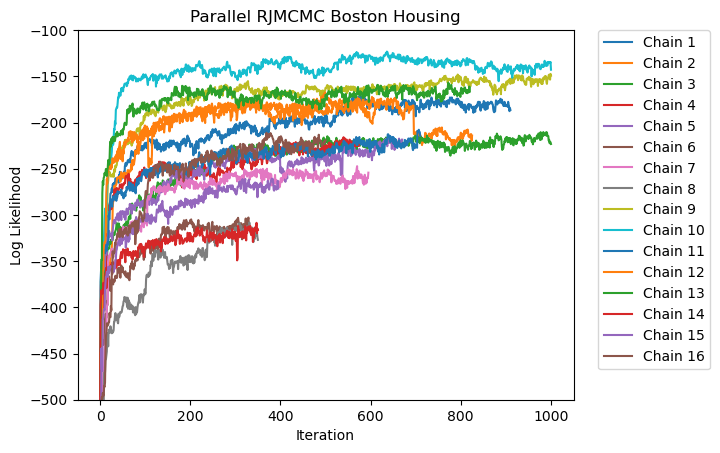

In [11]:
#Plot Log Posterior for Each Chain

for i=1:chains
    scores = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        scores[j] = get_score(trace)
    end
    plot(scores,label="Chain $i")
end
plt.title("Parallel RJMCMC Boston Housing")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood");
plt.ylim(-500,-100)

legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

In [7]:
for i=1:chains
    println("Chain $i iterations: $(length(traces[i]))")
end

Chain 1 iterations: 911
Chain 2 iterations: 826
Chain 3 iterations: 1001
Chain 4 iterations: 576
Chain 5 iterations: 671
Chain 6 iterations: 331
Chain 7 iterations: 596
Chain 8 iterations: 351
Chain 9 iterations: 1001
Chain 10 iterations: 1001
Chain 11 iterations: 711
Chain 12 iterations: 621
Chain 13 iterations: 821
Chain 14 iterations: 351
Chain 15 iterations: 396
Chain 16 iterations: 501


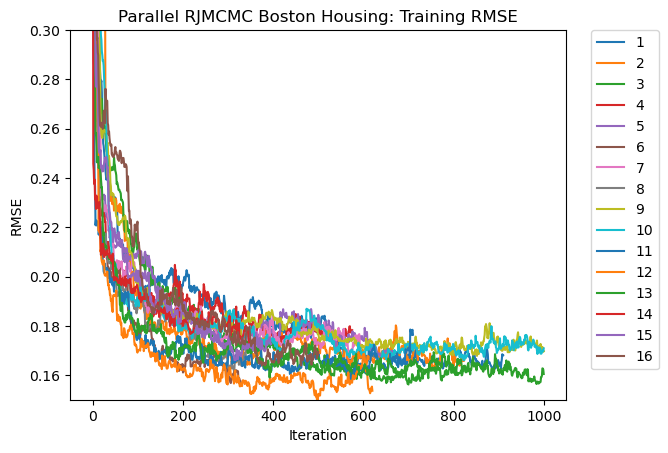

In [12]:
#Plot Train RMSE for Each Chain

for i=1:16
    rmses = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        pred_y = transpose(G(x_train,trace))[:,1]
        rmses[j] = mse_scaled(pred_y,y_train)
    end
    plot(rmses, label="$i")
end
plt.title("Parallel RJMCMC Boston Housing: Training RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.ylim(0.15,0.3)
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

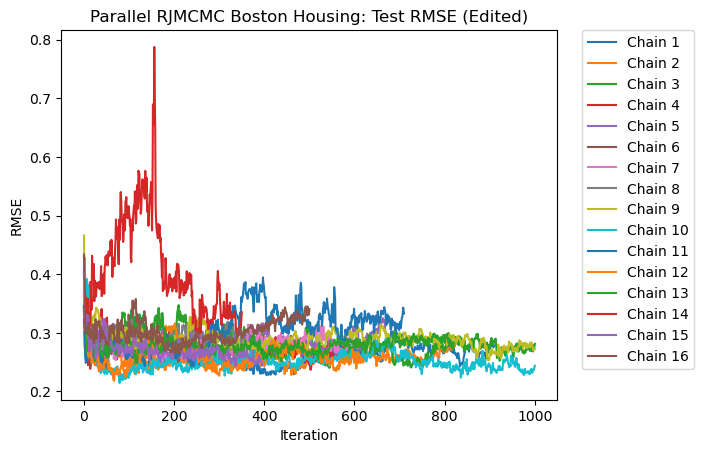

In [18]:
#Remove Outliers
y_new = [y_test[i] for i in 1:length(y_test)]
y_new = filter(x->x < 2.0,y_new)
x_subset = [(y_test[i] < 2.0 ? i : 0) for i in 1:length(y_test)]
x_subset = filter(x->x != 0,x_subset)
x_new = x_test[:,x_subset];

#Plot Test RMSE for Each Chain - No Outliers

for i=1:chains
    rmses = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        pred_y = transpose(G(x_new,trace))[:,1]
        rmses[j] = mse_scaled(pred_y,y_new)
    end
    plot(rmses,label="Chain $i")
end
plt.title("Parallel RJMCMC Boston Housing: Test RMSE (Edited)")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);
#plt.ylim(0.27,0.4);

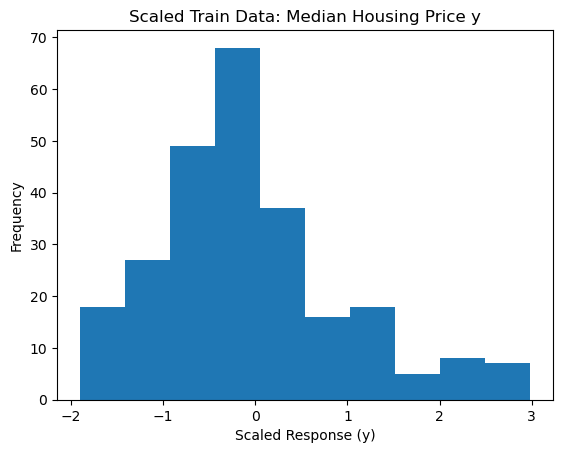

In [17]:
#hist(y_test)
hist(y_train);
plt.title("Scaled Train Data: Median Housing Price y")
plt.xlabel("Scaled Response (y)")
plt.ylabel("Frequency");


In [9]:
#Outlier Free RMSE

#Marginalize RMSE

j = 200

y_marginal = zeros(length(y_train))
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for i=j:length(traces2)
        trace = traces2[i]
        pred_y = transpose(G(x_train,trace))[:,1]
        y_marginal += pred_y
        new_mse = mse_scaled(pred_y, y_train)
        total_mse += new_mse
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_train)
#println(total_mse / number_traces)

println("Training Set Marginal RMSE: $mse")

y_marginal = zeros(length(y_new))
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for i=j:length(traces2)
        trace = traces2[i]
        pred_y = transpose(G(x_new,trace))[:,1]
        new_mse = mse_scaled(pred_y, y_new)
        total_mse += new_mse
        y_marginal += pred_y
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_new)
#println(total_mse / number_traces)

println("Test Set Marginal RMSE: $mse")

Training Set Marginal RMSE: 0.14670509368315593
Test Set Marginal RMSE: 0.252082724771799


In [26]:
#Outlier Free RMSE per Chain
j=1

for i=1:chains
    traces2 = traces[i]
    y_marginal = zeros(length(y_new))
    for v=j:length(traces2)
        trace = traces2[v]
        pred_y = transpose(G(x_new,trace))[:,1]
        y_marginal += pred_y
    end
    y_marginal = y_marginal ./(length(traces2)-(j-1))
    mse = mse_scaled(y_marginal, y_new)
    println("No Outliers: $mse")
end

No Outliers: 0.23012220182054677
No Outliers: 0.24183462642012454
No Outliers: 0.26614215423106674
No Outliers: 0.2578264442387924
No Outliers: 0.2723246846760879
No Outliers: 0.2651637466095842
No Outliers: 0.2603903920211601
No Outliers: 0.27395512514073345
No Outliers: 0.27042336058604327
No Outliers: 0.23390302466109592
No Outliers: 0.2834176409877677
No Outliers: 0.24354375532594089
No Outliers: 0.2634029860528873
No Outliers: 0.36519590518354456
No Outliers: 0.2537867811091412
No Outliers: 0.28063895218275503


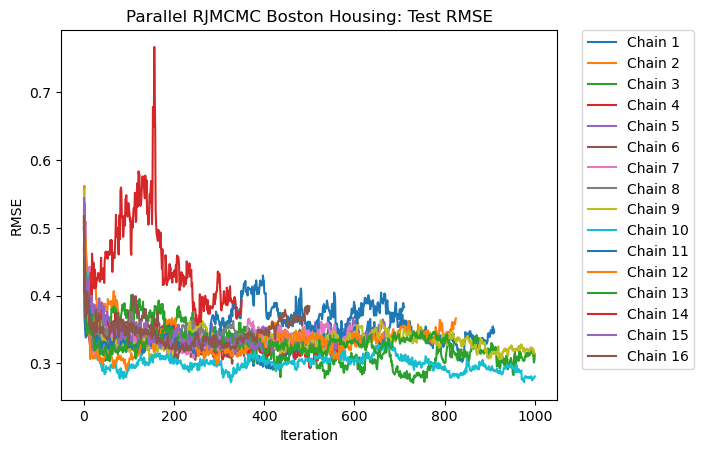

In [15]:
#Plot Test RMSE for Each Chain

for i=1:chains
    rmses = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        pred_y = transpose(G(x_test,trace))[:,1]
        rmses[j] = mse_scaled(pred_y,y_test)
    end
    plot(rmses,label="Chain $i")
end
plt.title("Parallel RJMCMC Boston Housing: Test RMSE")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
#plt.ylim(0.27,0.4)
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

In [12]:
#Marginalize RMSE

j = 1

y_marginal = zeros(length(y_train))
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for i=j:length(traces2)
        trace = traces2[i]
        pred_y = transpose(G(x_train,trace))[:,1]
        y_marginal += pred_y
        new_mse = mse_scaled(pred_y, y_train)
        total_mse += new_mse
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_train)
println(total_mse / number_traces)

println("Training Set Marginal RMSE: $mse")

y_marginal = zeros(length(y_test))
number_traces = 0
total_mse = 0
for i=1:chains
    traces2 = traces[i]
    for i=j:length(traces2)
        trace = traces2[i]
        pred_y = transpose(G(x_test,trace))[:,1]
        new_mse = mse_scaled(pred_y, y_test)
        total_mse += new_mse
        y_marginal += pred_y
        number_traces += 1
    end
end
y_marginal = y_marginal ./ number_traces
mse = mse_scaled(y_marginal, y_test)
println(total_mse / number_traces)

println("Test Set Marginal RMSE: $mse")

0.18307073727167397
Training Set Marginal RMSE: 0.1514308034974781
0.3376212560235238
Test Set Marginal RMSE: 0.30962231015013847


In [25]:
#Marginalize all RMSEs

j = 1


for i=1:chains
    traces2 = traces[i]
    y_marginal = zeros(length(y_train))
    for v=j:length(traces2)
        trace = traces2[v]
        pred_y = transpose(G(x_train,trace))[:,1]
        y_marginal += pred_y
    end
    y_marginal = y_marginal ./(length(traces2)-(j-1))
    mse = mse_scaled(y_marginal, y_train)
    println("Chain $i Training Set Marginal RMSE: $(round(mse,digits=3))")
end

for i=1:chains
    traces2 = traces[i]
    y_marginal = zeros(length(y_train))
    for v=j:length(traces2)
        trace = traces2[v]
        pred_y = transpose(G(x_test,trace))[:,1]
        y_marginal += pred_y
    end
    y_marginal = y_marginal ./(length(traces2)-(j-1))
    mse = mse_scaled(y_marginal, y_test)
    println("Test Set Marginal RMSE: $(round(mse,digits=3))")
end

Chain 1 Training Set Marginal RMSE: 0.16
Chain 2 Training Set Marginal RMSE: 0.162
Chain 3 Training Set Marginal RMSE: 0.158
Chain 4 Training Set Marginal RMSE: 0.173
Chain 5 Training Set Marginal RMSE: 0.169
Chain 6 Training Set Marginal RMSE: 0.16
Chain 7 Training Set Marginal RMSE: 0.17
Chain 8 Training Set Marginal RMSE: 0.166
Chain 9 Training Set Marginal RMSE: 0.163
Chain 10 Training Set Marginal RMSE: 0.163
Chain 11 Training Set Marginal RMSE: 0.156
Chain 12 Training Set Marginal RMSE: 0.149
Chain 13 Training Set Marginal RMSE: 0.156
Chain 14 Training Set Marginal RMSE: 0.176
Chain 15 Training Set Marginal RMSE: 0.173
Chain 16 Training Set Marginal RMSE: 0.169
Test Set Marginal RMSE: 0.308
Test Set Marginal RMSE: 0.325
Test Set Marginal RMSE: 0.312
Test Set Marginal RMSE: 0.318
Test Set Marginal RMSE: 0.326
Test Set Marginal RMSE: 0.318
Test Set Marginal RMSE: 0.323
Test Set Marginal RMSE: 0.33
Test Set Marginal RMSE: 0.317
Test Set Marginal RMSE: 0.287
Test Set Marginal RMSE: 0

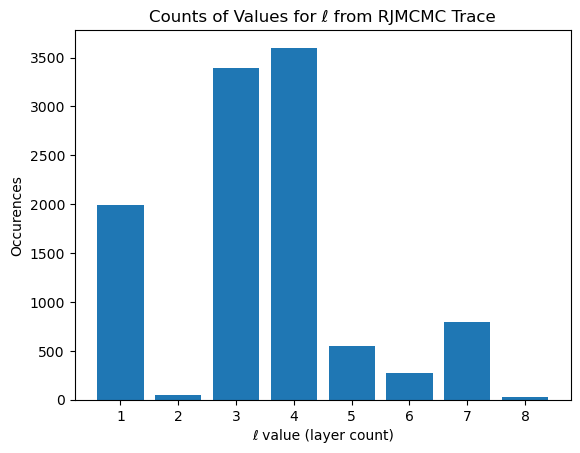

In [8]:
#Bar Plot of l estimates

ls = [[traces[i][j][:l] for j=1:length(traces[i])] for i=1:chains]
ls = collect(Iterators.flatten(ls))

counts = [sum([l_list[ls[i]] == j for i in 1:length(ls)]) for j in l_list]
bar(l_list,counts)

plt.title("Counts of Values for ℓ from RJMCMC Trace")
plt.xlabel("ℓ value (layer count)")
plt.ylabel("Occurences");

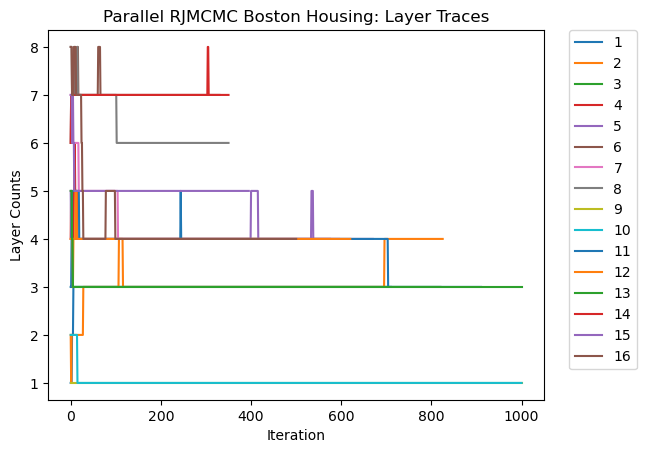

In [20]:
#Trace Plot for l
#Plot Train RMSE for Each Chain

for i=1:chains
    chain_ls = zeros(length(traces[i]))
    for j=1:length(traces[i])
        trace = traces[i][j]
        chain_ls[j] = trace[:l]
    end
    plot(chain_ls, label="$i")
end
plt.title("Parallel RJMCMC Boston Housing: Layer Traces")
plt.xlabel("Iteration")
plt.ylabel("Layer Counts")
legend(bbox_to_anchor=[1.05,1],loc=2,borderaxespad=0);

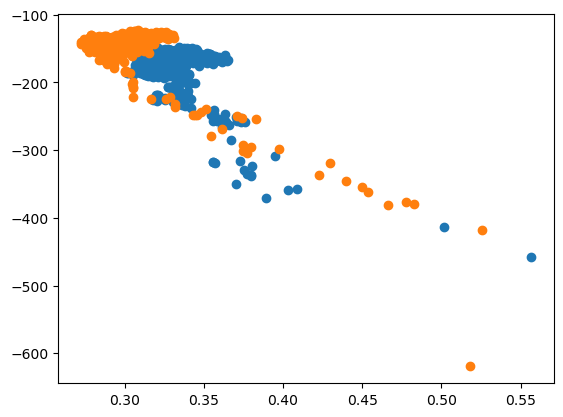

In [67]:
#RMSE Correlation with Log Posterior
for j=9:10
    current_chain = j
    chain_scores = []
    chain_MSES = []
    chain_obs = obs_master
    chain_obs[:y] = y_test
    for i =1:length(traces[current_chain])
        current_trace = traces[current_chain][i]
        push!(chain_scores,get_score(current_trace))
        pred_y = transpose(G(x_test,current_trace))[:,1]
        current_mse = mse_scaled(pred_y, y_test)
        push!(chain_MSES,current_mse)
    end
    scatter(chain_MSES,chain_scores)
    #plot(chain_MSES)
end

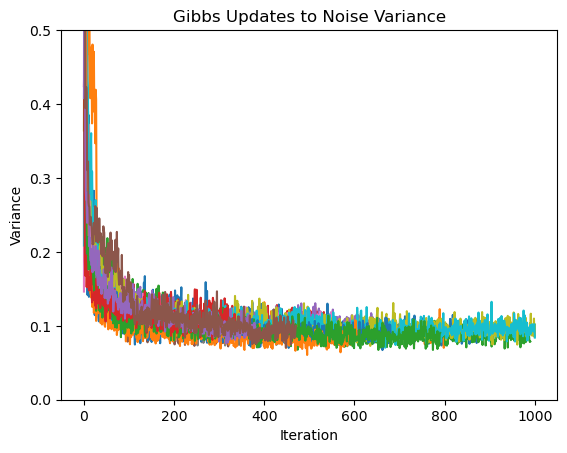

In [17]:
#Plot some hyperparameters
for j=1:16
    chain = j
    taus = [1/traces[chain][i][:τᵧ] for i=1:length(traces[chain])]
    plot(taus)
end
plt.title("Gibbs Updates to Noise Variance")
plt.xlabel("Iteration")
plt.ylabel("Variance")
plt.ylim(0,0.5);

In [23]:
chain = traces[10]
for i=1:length(chain)
    println(chain[i][(:W,1)][1])
end

0.08032428300775067
0.2676543361478231
0.21997099338188436
0.26010839068356273
0.33017344066423804
0.4075326846387715
0.31529721291140367
0.3282387397687352
0.3647655036039253
0.24475037343956293
0.2968175923777483
0.32459758918347625
0.3310036261943104
0.2715267982748624
0.2786958743208857
0.38788744465325353
0.08158821937164133
0.18717717254465685
0.1539861966174193
0.20123004746555173
0.20123004746555173
0.23395056211041104
0.25862463376332256
0.24989822958966476
0.28234240828683776
0.2650299607230455
0.2832593637726486
0.29696513645010214
0.23969572913328455
0.26782126525096905
0.15946673540509518
0.18799220015510085
0.18799220015510085
0.23364309411508236
0.2575929920695864
0.2163949349231508
0.21083959178955783
0.20961421602736893
0.14938550388503846
0.15199351972881975
0.1445548396951707
0.10816043805856385
0.09728618917283821
0.1280394276562685
0.12570129103949765
0.08918407539469722
0.06602334618790012
0.02866948838651831
0.03406788048019954
0.051128095914803696
-0.00738663643

0.10551290545492761
0.1731547786936349
0.1731547786936349
0.1731547786936349
0.19289257019127878
0.17615329615538877
0.26811321971383834
0.2773260255729948
0.29616752533587437
0.29097202087613033
0.31109804670025465
0.2597794602599225
0.15041231225437163
0.1458422649358601
0.14630388849757078
0.11106782561856704
0.08156246883116165
0.08387659184520042
0.06698980990081665
0.066082581461832
0.1056795101901725
0.004598598960179646
-0.023751442409576724
0.046293783201256294
0.013073637292210063
0.03395231984171947
-0.0009487953441726362
-0.018375352916544026
-0.022478126662078532
-0.05519810699692984
-0.030535280511543077
-0.03261186236280603
-0.019952354730403014
-0.007687660588954163
-0.016090213080277707
0.0074967872459420866
-0.004249048866168152
0.009062075027759978
0.02178240012577886
0.02450816318528548
0.0010461277212046993
-0.0034296731669353807
0.012273338837479993
0.05444046012394471
0.05074809233059949
0.05074809233059949
0.0501715313983713
-0.037140408927497634
-0.043378354709